# Preparation of the input for regression

- Input: FC Features: difference 1h-baseline FC from voxels to ROIs (median)
- for each participant you have one matrix 18 x 25 -> split in 18 x 10 (1. 5 voxel from s24 + 5 voxel from s32 & 2. 10voxel from s32) & flatten to be 1 x 180
- Combine all participants in matrix: samples x 180
- standardize the input

In [99]:
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNetCV
import os
import copy
import seaborn as sns
from sklearn.linear_model import enet_path
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [2]:
# read in MRS data
glu_res_data = pd.read_csv('C:/Users/canlab/Desktop/Masterthesis_python/data/Jenny_glutamate_and_gm_values.csv')

In [3]:
s24 = np.load('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/LargestChange_voxels/largest_5_voxels_s24', allow_pickle=True)
s32 = np.load('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/LargestChange_voxels/largest_10_voxels_s32', allow_pickle=True)
p32 = np.load('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/LargestChange_voxels/largest_10_voxels_p32', allow_pickle=True)
#ofc5 = np.load('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/LargestChange_voxels/largest_3_voxels_ofc5', allow_pickle=True)

In [124]:
s24

,x,y,ROI,ID,Dist,Diff,Diff_k_p
5746,-0.443762,0.365012,s24,334197,5.164898,2.576954,6.938511
6026,-2.672312,5.033516,s24,344029,9.706677,4.681733,6.639201
5744,-2.618876,4.985831,s24,334110,9.654293,4.337812,6.183105
5379,-2.882548,-7.995244,s24,324465,3.548302,-0.004987,5.780503
5373,-3.003107,-8.374632,s24,324374,3.946344,0.431043,5.659387


In [5]:
# glu_tcr: total creatine - creatine + phosphocreatine
# gm: grey matter ratio in the MRS voxel of the subject
# glu_tcr_baseline_corrected/24h_corrected: residuals + intercept for the model glu_cr.... ~ gm_ratio
glu_res_data

,ID,treatment,glu_tcr_baseline,glu_tcr_24h,gm_baseline,gm_24h,glu_tcr_baseline_corrected,glu_tcr_24h_corrected,difference_24h_baseline
0,ap75,Placebo,0.684,0.640,0.7028,0.6806,0.650491,0.634923,-0.015568
1,bg52,Verum,0.769,0.387,0.7178,0.7392,0.734776,0.381486,-0.353290
2,bh98,Verum,0.675,0.678,0.7579,0.7739,0.638864,0.672227,0.033363
3,bu45,Placebo,0.751,0.609,0.8396,0.8545,0.710969,0.602626,-0.108343
4,ce22,Verum,0.633,0.645,0.7326,0.8173,0.598071,0.638904,0.040833
5,cu52,Verum,0.563,0.689,0.7600,0.7108,0.526764,0.683698,0.156934
6,dp20,Placebo,0.591,0.552,0.8124,0.7780,0.552266,0.546197,-0.006069
7,dp37,Verum,0.398,0.660,0.7808,0.7754,0.360773,0.654216,0.293444
8,dp92,Placebo,0.667,0.631,0.7267,0.7110,0.632352,0.625697,-0.006655
9,dt27,Placebo,0.643,0.647,0.8340,0.7742,0.603236,0.641225,0.037989


In [6]:
ket = copy.deepcopy(glu_res_data[glu_res_data['treatment'] == 'Verum'])

In [7]:
placebo = copy.deepcopy(glu_res_data[glu_res_data['treatment'] == 'Placebo'])

In [8]:
ket.count()

ID                            27
treatment                     27
glu_tcr_baseline              27
glu_tcr_24h                   27
gm_baseline                   27
gm_24h                        27
glu_tcr_baseline_corrected    27
glu_tcr_24h_corrected         27
difference_24h_baseline       27
dtype: int64

In [9]:
placebo.count()

ID                            26
treatment                     26
glu_tcr_baseline              26
glu_tcr_24h                   26
gm_baseline                   26
gm_24h                        26
glu_tcr_baseline_corrected    26
glu_tcr_24h_corrected         26
difference_24h_baseline       26
dtype: int64

In [11]:
fc_feat = np.load('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Correlation_matrices/ketFC_features-bg52', allow_pickle=True)

In [13]:
matrix = fc_feat.to_numpy()
matrix

array([[ 2.06595288e-02, -5.60761652e-03,  4.11845458e-02,
        -3.01929157e-02, -5.84565838e-02, -3.65534863e-02,
        -3.02303783e-02,  2.04086709e-02, -5.01584189e-02,
        -2.75481772e-02, -6.44190979e-02,  1.24794296e-02,
        -2.26181707e-02,  1.02995485e-02, -2.24100120e-02,
         7.30689534e-03, -2.78697071e-02, -5.41108776e-02,
        -2.61342273e-02, -3.32019461e-02, -4.47276121e-04,
         1.07997778e-02,  1.70423977e-02, -1.77826771e-02,
        -1.25425206e-02],
       [ 8.32662851e-03, -2.68927520e-02, -2.94693212e-02,
        -9.66013390e-03, -1.23041716e-02, -9.48026194e-03,
        -2.19291792e-02, -3.62966106e-03,  1.15226055e-02,
         3.85230643e-02, -3.29108651e-04, -2.21378153e-02,
         2.35235239e-02, -5.05150204e-03, -7.03637841e-03,
        -3.17488524e-02,  1.87432380e-02, -6.45954127e-03,
         6.52874707e-03, -2.32811440e-02, -4.34112523e-03,
        -1.22038608e-02, -3.15297126e-04,  1.21640733e-02,
        -1.12087300e-02],
    

In [14]:
# complete subjects list
subj_list = copy.deepcopy(glu_res_data['ID'])

In [15]:
ket_subj_list=copy.deepcopy(ket['ID'])
placebo_subj_list=copy.deepcopy(placebo['ID'])

In [16]:
ket_subj_list

1     bg52
2     bh98
4     ce22
5     cu52
7     dp37
14    fy78
16    gs63
18    hw95
19    hy97
20    ia24
21    ia45
23    ii39
24    il04
25    ju09
26    jw73
28    kd21
31    kw91
35    op18
38    px00
39    qe30
41    sr21
43    tt42
44    uf97
45    vg84
48    wo30
49    ww25
52    yp84
Name: ID, dtype: object

### Prepare Y values for elastic net prediction

In [17]:
split_df = glu_res_data.groupby('treatment')
# get the median correlation of the ROIs
ket_df = split_df.get_group('Verum') 
pl_df = split_df.get_group('Placebo') 

In [18]:
ket_df

,ID,treatment,glu_tcr_baseline,glu_tcr_24h,gm_baseline,gm_24h,glu_tcr_baseline_corrected,glu_tcr_24h_corrected,difference_24h_baseline
1,bg52,Verum,0.769,0.387,0.7178,0.7392,0.734776,0.381486,-0.353290
2,bh98,Verum,0.675,0.678,0.7579,0.7739,0.638864,0.672227,0.033363
4,ce22,Verum,0.633,0.645,0.7326,0.8173,0.598071,0.638904,0.040833
5,cu52,Verum,0.563,0.689,0.7600,0.7108,0.526764,0.683698,0.156934
7,dp37,Verum,0.398,0.660,0.7808,0.7754,0.360773,0.654216,0.293444
14,fy78,Verum,0.579,0.634,0.7021,0.7025,0.545525,0.628760,0.083235
16,gs63,Verum,0.566,0.478,0.7371,0.7667,0.530856,0.472281,-0.058575
18,hw95,Verum,0.683,0.611,0.7335,0.7378,0.648028,0.605497,-0.042531
19,hy97,Verum,0.568,0.876,0.7194,0.7143,0.533700,0.870672,0.336972
20,ia24,Verum,0.645,0.608,0.7844,0.7839,0.607601,0.602153,-0.005448


In [122]:
ket_MRS= ket_df[['difference_24h_baseline']]
target=pd.DataFrame(ket_MRS)

In [125]:
p_MRS= pl_df[['difference_24h_baseline']]
p_target=pd.DataFrame(p_MRS)

In [91]:
p_MRS.to_pickle('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Elastic_net/Y_Placebo_MRS')

In [92]:
ket_MRS.to_pickle('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Elastic_net/Y_Ketamine_MRS')

In [123]:
# get csv file from MRS values
target.to_csv('ket_MRS.csv')

In [126]:
p_target.to_csv('p_MRS.csv')

In [22]:
s32[:5].index.to_list()

[2529, 3635, 2997, 2387, 2417]

In [45]:
s32

,x,y,ROI,ID,Dist,Diff,Diff_k_p
2529,0.013487,-1.276174,s32,275319,5.168566,4.566237,7.915159
3635,-0.289448,-0.882661,s32,294618,5.441076,5.020826,6.395710
2997,-0.381338,-1.451498,s32,284789,4.870731,4.383745,5.968472
2387,-0.304378,-1.378567,s32,274955,4.963983,4.810366,5.479500
2417,-0.354270,-1.560581,s32,275046,4.775540,4.585230,5.294158
2972,-0.283958,-1.373041,s32,284698,4.975708,4.574548,4.972117
2530,-0.154410,-1.334297,s32,275320,5.054990,4.801171,4.933331
2949,-0.270026,-1.338385,s32,284607,5.012999,4.598828,4.806849
2493,-0.331471,-1.612157,s32,275232,4.734041,3.845223,4.804449
3019,-0.304363,-1.479554,s32,284880,4.868277,4.546166,4.736333


**So I'm testing out different inputs for the elastic net prediction:**

- 5 voxels each from s24 and s32: X_1
- 10 voxels from s32: X_2

In [37]:
# 2 different inputs for elastic net
# read in subject FC feature
# then extract the columns according to desired input
# then transfer these to numpy arrays
# these matrices can then be flattened
# append them to lists that include all subjects

In [51]:
# creating indices for X_1
s24_index_X_1= s24[:5].index.to_list()
s32_index_X_1= s32[:5].index.to_list()

X_1_list=[s24_index_X_1,s32_index_X_1]

# creating indices for X_3
X2_indices = s32.index.to_list()

In [52]:
X1_indices=[]
for item in X_1_list:
    for index in item:
        X1_indices.append(index)
X1_indices

[5746, 6026, 5744, 5379, 5373, 2529, 3635, 2997, 2387, 2417]

In [53]:
X2_indices

[2529, 3635, 2997, 2387, 2417, 2972, 2530, 2949, 2493, 3019]

#### Create feature names

In [67]:
# X_1
fc_labels_X1=[]
for ind in fc_feat.index:
    for col in X1_indices:
        name=str(col)+'_'+ind
        fc_labels_X1.append(copy.deepcopy(name))

In [68]:
fc_labels_X1

['5746_25',
 '6026_25',
 '5744_25',
 '5379_25',
 '5373_25',
 '2529_25',
 '3635_25',
 '2997_25',
 '2387_25',
 '2417_25',
 '5746_33',
 '6026_33',
 '5744_33',
 '5379_33',
 '5373_33',
 '2529_33',
 '3635_33',
 '2997_33',
 '2387_33',
 '2417_33',
 '5746_Caudate',
 '6026_Caudate',
 '5744_Caudate',
 '5379_Caudate',
 '5373_Caudate',
 '2529_Caudate',
 '3635_Caudate',
 '2997_Caudate',
 '2387_Caudate',
 '2417_Caudate',
 '5746_FP2',
 '6026_FP2',
 '5744_FP2',
 '5379_FP2',
 '5373_FP2',
 '2529_FP2',
 '3635_FP2',
 '2997_FP2',
 '2387_FP2',
 '2417_FP2',
 '5746_NAcc',
 '6026_NAcc',
 '5744_NAcc',
 '5379_NAcc',
 '5373_NAcc',
 '2529_NAcc',
 '3635_NAcc',
 '2997_NAcc',
 '2387_NAcc',
 '2417_NAcc',
 '5746_OFC1',
 '6026_OFC1',
 '5744_OFC1',
 '5379_OFC1',
 '5373_OFC1',
 '2529_OFC1',
 '3635_OFC1',
 '2997_OFC1',
 '2387_OFC1',
 '2417_OFC1',
 '5746_OFC2',
 '6026_OFC2',
 '5744_OFC2',
 '5379_OFC2',
 '5373_OFC2',
 '2529_OFC2',
 '3635_OFC2',
 '2997_OFC2',
 '2387_OFC2',
 '2417_OFC2',
 '5746_OFC3',
 '6026_OFC3',
 '5744_OFC3'

In [69]:
# X_2
fc_labels_X2=[]
for ind in fc_feat.index:
    for col in X2_indices:
        name=str(col)+'_'+ind
        fc_labels_X2.append(copy.deepcopy(name))

In [70]:
fc_labels_X2

['2529_25',
 '3635_25',
 '2997_25',
 '2387_25',
 '2417_25',
 '2972_25',
 '2530_25',
 '2949_25',
 '2493_25',
 '3019_25',
 '2529_33',
 '3635_33',
 '2997_33',
 '2387_33',
 '2417_33',
 '2972_33',
 '2530_33',
 '2949_33',
 '2493_33',
 '3019_33',
 '2529_Caudate',
 '3635_Caudate',
 '2997_Caudate',
 '2387_Caudate',
 '2417_Caudate',
 '2972_Caudate',
 '2530_Caudate',
 '2949_Caudate',
 '2493_Caudate',
 '3019_Caudate',
 '2529_FP2',
 '3635_FP2',
 '2997_FP2',
 '2387_FP2',
 '2417_FP2',
 '2972_FP2',
 '2530_FP2',
 '2949_FP2',
 '2493_FP2',
 '3019_FP2',
 '2529_NAcc',
 '3635_NAcc',
 '2997_NAcc',
 '2387_NAcc',
 '2417_NAcc',
 '2972_NAcc',
 '2530_NAcc',
 '2949_NAcc',
 '2493_NAcc',
 '3019_NAcc',
 '2529_OFC1',
 '3635_OFC1',
 '2997_OFC1',
 '2387_OFC1',
 '2417_OFC1',
 '2972_OFC1',
 '2530_OFC1',
 '2949_OFC1',
 '2493_OFC1',
 '3019_OFC1',
 '2529_OFC2',
 '3635_OFC2',
 '2997_OFC2',
 '2387_OFC2',
 '2417_OFC2',
 '2972_OFC2',
 '2530_OFC2',
 '2949_OFC2',
 '2493_OFC2',
 '3019_OFC2',
 '2529_OFC3',
 '3635_OFC3',
 '2997_OFC3'

In [62]:
fc_feat[X1_indices]

,5746,6026,5744,5379,5373,2529,3635,2997,2387,2417
label,,,,,,,,,,
25,0.020660,-0.005608,0.041185,-0.030193,-0.058457,-0.036553,-0.030230,0.020409,-0.050158,-0.027548
33,0.008327,-0.026893,-0.029469,-0.009660,-0.012304,-0.009480,-0.021929,-0.003630,0.011523,0.038523
Caudate,-0.049476,0.026619,0.035506,-0.005955,-0.007169,-0.048430,-0.038082,-0.070182,-0.019675,-0.030513
FP2,0.037526,-0.002197,0.017151,0.014690,-0.051438,-0.110616,0.035687,-0.071948,-0.001195,-0.036622
NAcc,-0.001411,-0.010794,-0.007379,-0.029498,-0.044645,-0.028794,0.000216,-0.029160,-0.003754,0.029139
OFC1,-0.077982,0.087008,0.058457,0.011466,-0.058871,-0.011570,-0.005777,0.140729,-0.040379,-0.035834
OFC2,-0.028808,0.002673,-0.005022,0.013730,-0.020165,-0.020362,-0.012091,0.023638,-0.033826,-0.037531
OFC3,-0.013285,0.010327,0.013008,-0.002094,-0.024158,-0.006761,-0.022292,-0.001561,-0.016189,-0.004979
OFC4,-0.003795,0.025721,0.007824,-0.046630,-0.034966,0.020142,-0.001345,0.038775,-0.035665,0.033779


In [61]:
fc_feat[X2_indices]

,2529,3635,2997,2387,2417,2972,2530,2949,2493,3019
label,,,,,,,,,,
25,-0.036553,-0.030230,0.020409,-0.050158,-0.027548,-0.064419,0.012479,-0.022618,0.010300,-0.022410
33,-0.009480,-0.021929,-0.003630,0.011523,0.038523,-0.000329,-0.022138,0.023524,-0.005052,-0.007036
Caudate,-0.048430,-0.038082,-0.070182,-0.019675,-0.030513,-0.014324,-0.049332,-0.058213,-0.070535,-0.040012
FP2,-0.110616,0.035687,-0.071948,-0.001195,-0.036622,-0.000439,0.027464,-0.030158,-0.114864,-0.035479
NAcc,-0.028794,0.000216,-0.029160,-0.003754,0.029139,-0.011031,0.012449,-0.021208,-0.046116,-0.025916
OFC1,-0.011570,-0.005777,0.140729,-0.040379,-0.035834,0.032963,-0.007679,0.005193,0.147695,-0.005210
OFC2,-0.020362,-0.012091,0.023638,-0.033826,-0.037531,-0.030958,-0.007149,-0.022217,0.026454,0.013656
OFC3,-0.006761,-0.022292,-0.001561,-0.016189,-0.004979,-0.024049,0.009491,-0.027822,0.015573,0.009612
OFC4,0.020142,-0.001345,0.038775,-0.035665,0.033779,0.003162,0.043541,0.010575,0.057948,0.005404


In [63]:
fc=fc_feat[X2_indices].to_numpy()
fc

array([[-0.03655349, -0.03023038,  0.02040867, -0.05015842, -0.02754818,
        -0.0644191 ,  0.01247943, -0.02261817,  0.01029955, -0.02241001],
       [-0.00948026, -0.02192918, -0.00362966,  0.01152261,  0.03852306,
        -0.00032911, -0.02213782,  0.02352352, -0.0050515 , -0.00703638],
       [-0.04842997, -0.03808197, -0.07018154, -0.01967451, -0.03051297,
        -0.01432367, -0.04933224, -0.05821288, -0.07053542, -0.04001184],
       [-0.11061583,  0.03568706, -0.07194803, -0.00119472, -0.03662212,
        -0.0004385 ,  0.02746403, -0.0301583 , -0.11486419, -0.03547945],
       [-0.02879358,  0.00021551, -0.02915962, -0.00375431,  0.02913916,
        -0.01103108,  0.01244948, -0.02120767, -0.04611571, -0.0259158 ],
       [-0.01157018, -0.00577673,  0.14072947, -0.0403787 , -0.03583419,
         0.03296319, -0.00767876,  0.00519254,  0.14769464, -0.00520985],
       [-0.02036178, -0.01209143,  0.02363757, -0.03382563, -0.03753064,
        -0.03095803, -0.0071488 , -0.02221691

In [64]:
flat_feat=fc.flatten()

In [65]:
X_1 = copy.deepcopy(flat_feat)

In [66]:
X_1

array([-0.03655349, -0.03023038,  0.02040867, -0.05015842, -0.02754818,
       -0.0644191 ,  0.01247943, -0.02261817,  0.01029955, -0.02241001,
       -0.00948026, -0.02192918, -0.00362966,  0.01152261,  0.03852306,
       -0.00032911, -0.02213782,  0.02352352, -0.0050515 , -0.00703638,
       -0.04842997, -0.03808197, -0.07018154, -0.01967451, -0.03051297,
       -0.01432367, -0.04933224, -0.05821288, -0.07053542, -0.04001184,
       -0.11061583,  0.03568706, -0.07194803, -0.00119472, -0.03662212,
       -0.0004385 ,  0.02746403, -0.0301583 , -0.11486419, -0.03547945,
       -0.02879358,  0.00021551, -0.02915962, -0.00375431,  0.02913916,
       -0.01103108,  0.01244948, -0.02120767, -0.04611571, -0.0259158 ,
       -0.01157018, -0.00577673,  0.14072947, -0.0403787 , -0.03583419,
        0.03296319, -0.00767876,  0.00519254,  0.14769464, -0.00520985,
       -0.02036178, -0.01209143,  0.02363757, -0.03382563, -0.03753064,
       -0.03095803, -0.0071488 , -0.02221691,  0.02645433,  0.01

In [71]:
X_1

array([-0.03655349, -0.03023038,  0.02040867, -0.05015842, -0.02754818,
       -0.0644191 ,  0.01247943, -0.02261817,  0.01029955, -0.02241001,
       -0.00948026, -0.02192918, -0.00362966,  0.01152261,  0.03852306,
       -0.00032911, -0.02213782,  0.02352352, -0.0050515 , -0.00703638,
       -0.04842997, -0.03808197, -0.07018154, -0.01967451, -0.03051297,
       -0.01432367, -0.04933224, -0.05821288, -0.07053542, -0.04001184,
       -0.11061583,  0.03568706, -0.07194803, -0.00119472, -0.03662212,
       -0.0004385 ,  0.02746403, -0.0301583 , -0.11486419, -0.03547945,
       -0.02879358,  0.00021551, -0.02915962, -0.00375431,  0.02913916,
       -0.01103108,  0.01244948, -0.02120767, -0.04611571, -0.0259158 ,
       -0.01157018, -0.00577673,  0.14072947, -0.0403787 , -0.03583419,
        0.03296319, -0.00767876,  0.00519254,  0.14769464, -0.00520985,
       -0.02036178, -0.01209143,  0.02363757, -0.03382563, -0.03753064,
       -0.03095803, -0.0071488 , -0.02221691,  0.02645433,  0.01

In [72]:
X_1=np.vstack((X_1, flat_feat))

In [102]:
del X_1

In [73]:
np.append(flat_feat,flat_feat)

array([-0.03655349, -0.03023038,  0.02040867, -0.05015842, -0.02754818,
       -0.0644191 ,  0.01247943, -0.02261817,  0.01029955, -0.02241001,
       -0.00948026, -0.02192918, -0.00362966,  0.01152261,  0.03852306,
       -0.00032911, -0.02213782,  0.02352352, -0.0050515 , -0.00703638,
       -0.04842997, -0.03808197, -0.07018154, -0.01967451, -0.03051297,
       -0.01432367, -0.04933224, -0.05821288, -0.07053542, -0.04001184,
       -0.11061583,  0.03568706, -0.07194803, -0.00119472, -0.03662212,
       -0.0004385 ,  0.02746403, -0.0301583 , -0.11486419, -0.03547945,
       -0.02879358,  0.00021551, -0.02915962, -0.00375431,  0.02913916,
       -0.01103108,  0.01244948, -0.02120767, -0.04611571, -0.0259158 ,
       -0.01157018, -0.00577673,  0.14072947, -0.0403787 , -0.03583419,
        0.03296319, -0.00767876,  0.00519254,  0.14769464, -0.00520985,
       -0.02036178, -0.01209143,  0.02363757, -0.03382563, -0.03753064,
       -0.03095803, -0.0071488 , -0.02221691,  0.02645433,  0.01

Function that creates Input X:
1. X_1: is 5 voxels from s24 & s32 respectively 
2. X_2: 10 voxels from s32

Yielding samples (27k / 26 p) x 180 matrices as input for regression analysis

In [84]:
def create_X(subj_list, treatment):
    
    # choose path according to saving directory dependend on treatment
    if treatment=='ket':
        path = 'C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Correlation_matrices/ketFC_features-'
    else:
        path = 'C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Correlation_matrices/placeboFC_features-'
        
    print(path)
    i=0
    
    for subj in subj_list:
        
        subj_name= str(subj)
        subj_path = path+subj_name
        # load features
        fc_feature = np.load(subj_path, allow_pickle=True)
        
        # extracting the columns for each input
        # X_1:
        X_1_feat= fc_feature[X1_indices].to_numpy()
        X_2_feat= fc_feature[X2_indices].to_numpy()
        #X_3_feat= fc_feature[X3_indices].to_numpy()
        #X_4_feat= fc_feature[X4_indices].to_numpy()
        
        # flatten matrix from each particpant & stacking them up for all participants
        if i==0:
            # first round 
            X_1 = copy.deepcopy(X_1_feat.flatten())
            X_2 = copy.deepcopy(X_2_feat.flatten())
            #X_3 = copy.deepcopy(X_3_feat.flatten())
            #X_4 = copy.deepcopy(X_4_feat.flatten())
        else:
            # all other rounds
            # vstack produces copy
            X_1 = np.vstack((X_1, X_1_feat.flatten()))
            X_2 = np.vstack((X_2, X_2_feat.flatten()))
            #X_3 = np.vstack((X_3, X_3_feat.flatten()))
            #X_4 = np.vstack((X_4, X_4_feat.flatten()))
            
        i+=1 

        
    return X_1,X_2


In [75]:
[X_1_k,X_2_k]=create_X(ket_subj_list, 'ket')

C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Correlation_matrices/ketFC_features-


In [79]:
pd.DataFrame(X_1_k)

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.020660,-0.005608,0.041185,-0.030193,-0.058457,-0.036553,-0.030230,0.020409,-0.050158,-0.027548,...,-0.021693,0.020103,0.015254,0.014119,-0.062897,-0.020762,0.011536,0.054552,-0.012363,0.031917
1,0.018063,0.010723,0.041459,-0.029035,-0.045968,-0.004066,-0.052749,-0.020847,-0.049894,0.004223,...,0.034455,-0.033930,-0.002818,0.009572,0.053438,-0.003447,0.009205,-0.012889,-0.016487,0.035816
2,0.018312,0.000357,-0.020992,-0.039164,0.013780,-0.051414,0.024129,0.018289,0.048153,0.048722,...,-0.011771,-0.007815,-0.025270,0.006798,-0.011719,0.017192,-0.031610,0.016974,0.001624,0.005542
3,0.011108,-0.028160,0.078615,0.081585,-0.015826,0.080635,0.143667,0.060242,-0.087534,0.002335,...,-0.005998,0.028487,0.053597,0.063986,-0.032338,0.037494,-0.024023,0.061054,-0.003651,0.006432
4,-0.005198,-0.037815,-0.056692,-0.008820,0.024371,-0.072914,-0.025323,0.005402,0.027415,-0.051341,...,0.015800,-0.043678,0.044564,0.018206,-0.023890,-0.067186,-0.065383,-0.011640,0.012491,0.025802
5,-0.067479,-0.059374,0.011223,-0.061973,-0.046137,0.113473,0.003191,0.043067,0.073376,-0.009587,...,-0.056089,0.042750,0.008294,-0.062565,-0.063913,0.024089,0.014587,0.019481,0.047911,0.090285
6,-0.035121,-0.035431,0.019192,0.071133,0.000851,-0.011997,0.009363,0.043654,-0.030128,0.005111,...,-0.010381,-0.043063,0.018175,0.019596,-0.030472,-0.023142,0.081234,-0.053882,0.014898,0.013288
7,-0.005386,-0.056204,0.017823,-0.023867,0.024779,0.038722,0.012371,-0.009137,0.051507,0.145813,...,0.008218,-0.064860,0.031839,-0.034370,-0.001959,-0.084269,0.062925,-0.032009,0.069791,0.206366
8,0.063866,0.071013,0.044556,0.011866,-0.112623,0.006392,-0.003944,0.011754,-0.010129,-0.065396,...,0.011831,0.118033,0.096087,-0.024294,-0.087661,-0.039572,-0.012645,0.041516,-0.056445,-0.044588
9,-0.028670,-0.023309,-0.083732,0.052011,0.021923,-0.018915,-0.047164,0.068327,0.051260,0.052409,...,-0.044643,0.027499,-0.020530,0.036043,0.020986,-0.086752,-0.059925,0.005508,-0.046069,0.000194


In [86]:
# label the features
x1_df=pd.DataFrame(X_1_k)
x1_df.columns=[fc_labels_X1]
x1_df.to_pickle('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Correlation_matrices/FC_features_comb_ket_s24_s32')
x1_df

,5746_25,6026_25,5744_25,5379_25,5373_25,2529_25,3635_25,2997_25,2387_25,2417_25,...,5746_s32,6026_s32,5744_s32,5379_s32,5373_s32,2529_s32,3635_s32,2997_s32,2387_s32,2417_s32
0,0.020660,-0.005608,0.041185,-0.030193,-0.058457,-0.036553,-0.030230,0.020409,-0.050158,-0.027548,...,-0.021693,0.020103,0.015254,0.014119,-0.062897,-0.020762,0.011536,0.054552,-0.012363,0.031917
1,0.018063,0.010723,0.041459,-0.029035,-0.045968,-0.004066,-0.052749,-0.020847,-0.049894,0.004223,...,0.034455,-0.033930,-0.002818,0.009572,0.053438,-0.003447,0.009205,-0.012889,-0.016487,0.035816
2,0.018312,0.000357,-0.020992,-0.039164,0.013780,-0.051414,0.024129,0.018289,0.048153,0.048722,...,-0.011771,-0.007815,-0.025270,0.006798,-0.011719,0.017192,-0.031610,0.016974,0.001624,0.005542
3,0.011108,-0.028160,0.078615,0.081585,-0.015826,0.080635,0.143667,0.060242,-0.087534,0.002335,...,-0.005998,0.028487,0.053597,0.063986,-0.032338,0.037494,-0.024023,0.061054,-0.003651,0.006432
4,-0.005198,-0.037815,-0.056692,-0.008820,0.024371,-0.072914,-0.025323,0.005402,0.027415,-0.051341,...,0.015800,-0.043678,0.044564,0.018206,-0.023890,-0.067186,-0.065383,-0.011640,0.012491,0.025802
5,-0.067479,-0.059374,0.011223,-0.061973,-0.046137,0.113473,0.003191,0.043067,0.073376,-0.009587,...,-0.056089,0.042750,0.008294,-0.062565,-0.063913,0.024089,0.014587,0.019481,0.047911,0.090285
6,-0.035121,-0.035431,0.019192,0.071133,0.000851,-0.011997,0.009363,0.043654,-0.030128,0.005111,...,-0.010381,-0.043063,0.018175,0.019596,-0.030472,-0.023142,0.081234,-0.053882,0.014898,0.013288
7,-0.005386,-0.056204,0.017823,-0.023867,0.024779,0.038722,0.012371,-0.009137,0.051507,0.145813,...,0.008218,-0.064860,0.031839,-0.034370,-0.001959,-0.084269,0.062925,-0.032009,0.069791,0.206366
8,0.063866,0.071013,0.044556,0.011866,-0.112623,0.006392,-0.003944,0.011754,-0.010129,-0.065396,...,0.011831,0.118033,0.096087,-0.024294,-0.087661,-0.039572,-0.012645,0.041516,-0.056445,-0.044588
9,-0.028670,-0.023309,-0.083732,0.052011,0.021923,-0.018915,-0.047164,0.068327,0.051260,0.052409,...,-0.044643,0.027499,-0.020530,0.036043,0.020986,-0.086752,-0.059925,0.005508,-0.046069,0.000194


In [87]:
# label the features
x2_df=pd.DataFrame(X_2_k)
x2_df.columns=[fc_labels_X2]
x2_df.to_pickle('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Correlation_matrices/FC_features_comb_ket_s32')
x2_df

,2529_25,3635_25,2997_25,2387_25,2417_25,2972_25,2530_25,2949_25,2493_25,3019_25,...,2529_s32,3635_s32,2997_s32,2387_s32,2417_s32,2972_s32,2530_s32,2949_s32,2493_s32,3019_s32
0,-0.036553,-0.030230,0.020409,-0.050158,-0.027548,-0.064419,0.012479,-0.022618,0.010300,-0.022410,...,-0.020762,0.011536,0.054552,-0.012363,0.031917,0.077639,-0.006720,0.015894,0.015021,0.026391
1,-0.004066,-0.052749,-0.020847,-0.049894,0.004223,-0.038697,-0.003397,-0.082689,0.005352,0.052784,...,-0.003447,0.009205,-0.012889,-0.016487,0.035816,0.026110,-0.023647,0.031027,0.027040,-0.040491
2,-0.051414,0.024129,0.018289,0.048153,0.048722,-0.045986,-0.022621,-0.015258,-0.062406,-0.037129,...,0.017192,-0.031610,0.016974,0.001624,0.005542,0.005985,0.003622,0.027144,-0.007794,0.025052
3,0.080635,0.143667,0.060242,-0.087534,0.002335,-0.007593,0.115338,-0.092195,-0.108324,0.093873,...,0.037494,-0.024023,0.061054,-0.003651,0.006432,0.022007,0.032316,-0.020940,-0.007471,0.029878
4,-0.072914,-0.025323,0.005402,0.027415,-0.051341,-0.014901,-0.000494,-0.004207,-0.032891,0.048033,...,-0.067186,-0.065383,-0.011640,0.012491,0.025802,-0.016835,-0.022671,-0.021263,0.009260,-0.014121
5,0.113473,0.003191,0.043067,0.073376,-0.009587,0.049625,-0.083621,0.037380,0.028313,0.019570,...,0.024089,0.014587,0.019481,0.047911,0.090285,0.036383,-0.019139,-0.004578,-0.029875,0.020100
6,-0.011997,0.009363,0.043654,-0.030128,0.005111,0.043999,0.065424,0.001315,-0.034541,-0.005484,...,-0.023142,0.081234,-0.053882,0.014898,0.013288,-0.008128,0.023340,0.008816,0.050004,-0.037538
7,0.038722,0.012371,-0.009137,0.051507,0.145813,-0.020637,-0.004935,-0.041227,0.015864,-0.043131,...,-0.084269,0.062925,-0.032009,0.069791,0.206366,-0.039110,-0.086996,-0.099819,0.051154,-0.073575
8,0.006392,-0.003944,0.011754,-0.010129,-0.065396,-0.040843,0.119680,-0.021705,-0.020540,0.003244,...,-0.039572,-0.012645,0.041516,-0.056445,-0.044588,0.002502,0.072508,0.002546,-0.019798,0.035744
9,-0.018915,-0.047164,0.068327,0.051260,0.052409,0.046553,-0.026171,0.080254,-0.009703,0.023607,...,-0.086752,-0.059925,0.005508,-0.046069,0.000194,-0.009924,-0.048461,-0.032516,-0.007982,-0.050410


In [88]:
[X_1_p,X_2_p]=create_X(placebo_subj_list, 'placebo')

C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Correlation_matrices/placeboFC_features-


In [358]:
np.save('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Elastic_net/X_3_p.npy', X_3_p)

In [89]:
# label the features
x1_p_df=pd.DataFrame(X_1_p)
x1_p_df.columns=[fc_labels_X1]
x1_p_df.to_pickle('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Correlation_matrices/FC_features_comb_placebo_s24_s32')
x1_p_df

,5746_25,6026_25,5744_25,5379_25,5373_25,2529_25,3635_25,2997_25,2387_25,2417_25,...,5746_s32,6026_s32,5744_s32,5379_s32,5373_s32,2529_s32,3635_s32,2997_s32,2387_s32,2417_s32
0,-0.007835,0.018275,-0.016795,-0.003226,0.003056,-0.009603,-0.007399,0.091115,0.057189,0.029336,...,-0.057362,0.024401,-0.031331,0.012970,0.005864,-0.033943,0.028135,0.095025,0.098768,0.060200
1,0.067431,0.065698,0.129257,-0.021830,-0.079551,0.083277,-0.002838,0.053065,-0.031495,0.064807,...,0.030911,0.010395,0.071649,-0.027638,-0.032791,0.107315,-0.046813,0.156653,0.093378,0.107609
2,0.038395,-0.016472,-0.058156,-0.060863,-0.038197,-0.072786,-0.012204,0.007265,-0.012861,-0.077858,...,-0.100210,-0.050828,-0.022918,-0.003071,-0.040360,-0.011825,-0.000570,-0.014204,-0.004927,-0.040600
3,0.005213,0.010788,0.071623,0.059613,-0.025557,-0.064697,0.115641,-0.048447,-0.015505,-0.174574,...,-0.056435,-0.090596,-0.020307,0.016450,-0.024894,0.092822,-0.000525,-0.101488,0.091175,-0.041894
4,0.014552,0.021755,-0.025006,-0.027311,-0.023815,0.118943,-0.061711,-0.113695,0.054328,0.071346,...,-0.054714,0.021318,-0.026812,-0.025429,-0.037009,0.032322,-0.018274,-0.051036,-0.076741,-0.044585
5,-0.013823,0.012358,0.044967,0.013543,0.028432,-0.053758,0.002307,0.005701,0.054473,0.029129,...,0.027493,0.011487,0.022535,0.007748,0.004089,-0.051012,0.050793,0.028699,0.065028,0.036188
6,-0.009437,-0.044909,-0.064272,-0.037452,-0.025872,-0.026005,0.060272,-0.097235,0.029349,0.002492,...,-0.061323,-0.000508,-0.034351,0.006219,-0.015481,-0.029413,-0.043181,0.004585,-0.025034,-0.063703
7,0.043653,0.011487,-0.000012,0.038794,0.000929,-0.033269,-0.011389,-0.019996,0.020581,-0.036549,...,0.015198,0.003573,-0.013919,0.025737,0.011995,-0.067836,-0.008974,-0.022972,-0.040488,0.070917
8,0.009440,0.000741,0.014540,-0.018908,-0.089152,-0.043608,-0.006970,0.045618,0.023211,-0.070252,...,-0.013124,0.090654,-0.004469,0.050983,0.078886,0.050685,0.030936,0.081925,0.059974,-0.007436
9,0.069306,0.017298,-0.032051,0.044527,-0.007036,-0.010166,0.047023,0.033817,-0.000024,-0.053906,...,0.022640,0.010784,0.006645,-0.001027,0.015791,-0.037665,-0.005767,-0.013985,-0.049171,-0.048883


In [90]:
# label the features
x2_p_df=pd.DataFrame(X_2_p)
np.save
x2_p_df.columns=[fc_labels_X2]
x2_p_df.to_pickle('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Correlation_matrices/FC_features_comb_placebo_s32')
x2_p_df

,2529_25,3635_25,2997_25,2387_25,2417_25,2972_25,2530_25,2949_25,2493_25,3019_25,...,2529_s32,3635_s32,2997_s32,2387_s32,2417_s32,2972_s32,2530_s32,2949_s32,2493_s32,3019_s32
0,-0.009603,-0.007399,0.091115,0.057189,0.029336,0.103995,0.019753,0.137355,0.048128,0.106218,...,-0.033943,0.028135,0.095025,0.098768,0.060200,0.076093,0.000519,0.089800,0.082718,0.077722
1,0.083277,-0.002838,0.053065,-0.031495,0.064807,0.049690,0.074119,0.031289,0.150900,0.063111,...,0.107315,-0.046813,0.156653,0.093378,0.107609,0.150069,0.128420,0.095152,0.125977,0.184492
2,-0.072786,-0.012204,0.007265,-0.012861,-0.077858,-0.055830,-0.020518,0.028436,-0.007278,0.066470,...,-0.011825,-0.000570,-0.014204,-0.004927,-0.040600,-0.011890,0.070110,0.044814,0.033568,-0.004975
3,-0.064697,0.115641,-0.048447,-0.015505,-0.174574,-0.080553,-0.158218,-0.133454,-0.118032,-0.046016,...,0.092822,-0.000525,-0.101488,0.091175,-0.041894,-0.103175,-0.040388,-0.069184,0.099313,-0.000407
4,0.118943,-0.061711,-0.113695,0.054328,0.071346,-0.103821,0.059740,-0.086882,-0.061566,-0.096995,...,0.032322,-0.018274,-0.051036,-0.076741,-0.044585,-0.111361,0.044927,-0.079920,-0.063857,-0.072982
5,-0.053758,0.002307,0.005701,0.054473,0.029129,-0.009080,-0.051207,0.027924,-0.006383,0.036634,...,-0.051012,0.050793,0.028699,0.065028,0.036188,0.036287,-0.010216,0.021996,0.006099,0.031316
6,-0.026005,0.060272,-0.097235,0.029349,0.002492,-0.097865,0.032936,-0.018381,-0.063110,-0.050542,...,-0.029413,-0.043181,0.004585,-0.025034,-0.063703,0.010263,-0.076162,0.023724,0.015005,0.012146
7,-0.033269,-0.011389,-0.019996,0.020581,-0.036549,0.012128,-0.051783,0.013274,-0.018486,0.014084,...,-0.067836,-0.008974,-0.022972,-0.040488,0.070917,-0.068954,-0.024661,-0.072565,-0.016944,0.003321
8,-0.043608,-0.006970,0.045618,0.023211,-0.070252,-0.050185,0.020410,-0.019677,-0.052909,0.006359,...,0.050685,0.030936,0.081925,0.059974,-0.007436,0.104948,0.057410,0.058188,-0.093732,-0.028736
9,-0.010166,0.047023,0.033817,-0.000024,-0.053906,-0.003029,-0.001914,0.014972,-0.033823,0.019374,...,-0.037665,-0.005767,-0.013985,-0.049171,-0.048883,0.045951,0.013114,0.033004,-0.012197,0.014072


## Standardize

Standardize the X input column wise

In [101]:
scaler = StandardScaler()
#print(scaler.fit(data))
StandardScaler()

StandardScaler(copy=True, with_mean=True, with_std=True)

In [102]:
# standardize the features
X_1_k_st=scaler.fit_transform(X_1_k)

In [106]:
X_1_k_st

array([[ 0.18496237,  0.184162  ,  0.96506215, ...,  0.95296682,
        -0.21733859,  0.3665513 ],
       [ 0.11961058,  0.66690043,  0.97076759, ..., -0.48236569,
        -0.31002751,  0.43947099],
       [ 0.12589348,  0.36046607, -0.32906379, ...,  0.15321077,
         0.09704126, -0.12682745],
       ...,
       [-0.0031446 ,  2.4112177 ,  0.32471118, ..., -1.00602067,
         0.13051661, -0.98297024],
       [ 0.40998815,  0.17506861,  0.31967664, ..., -0.20403083,
        -0.78257709, -0.9123522 ],
       [-0.24664538, -1.2230091 , -0.73172928, ...,  0.46869745,
        -0.22972142, -0.58333664]])

In [107]:
x1_k_st_df=pd.DataFrame(X_1_k_st)
# connect with features names
x1_k_st_df.columns=[fc_labels_X1]
x1_k_st_df.to_pickle('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Correlation_matrices/Input_ket_s24_s32_standardized')
x1_k_st_df

,5746_25,6026_25,5744_25,5379_25,5373_25,2529_25,3635_25,2997_25,2387_25,2417_25,...,5746_s32,6026_s32,5744_s32,5379_s32,5373_s32,2529_s32,3635_s32,2997_s32,2387_s32,2417_s32
0,0.184962,0.184162,0.965062,-0.672728,-0.969898,-0.879416,-0.435173,0.003577,-0.899605,-0.666965,...,-0.444277,0.440372,0.258280,0.150920,-1.210343,-0.337090,0.346033,0.952967,-0.217339,0.366551
1,0.119611,0.666900,0.970768,-0.651627,-0.764038,-0.390976,-0.877088,-0.807023,-0.895699,-0.092117,...,0.642227,-0.800150,-0.206746,0.042768,1.023590,-0.058309,0.299285,-0.482366,-0.310028,0.439471
2,0.125893,0.360466,-0.329064,-0.836155,0.220885,-1.102842,0.631605,-0.038066,0.554031,0.713008,...,-0.252284,-0.200574,-0.784498,-0.023217,-0.227578,0.273984,-0.519530,0.153211,0.097041,-0.126827
3,-0.055410,-0.482471,1.744144,1.363446,-0.267159,0.882475,2.977502,0.786242,-1.452245,-0.126276,...,-0.140569,0.632848,1.244957,1.337057,-0.623530,0.600864,-0.367325,1.091352,-0.021512,-0.110174
4,-0.465795,-0.767874,-1.072117,-0.283397,0.395465,-1.426080,-0.338877,-0.291287,0.247397,-1.097452,...,0.281239,-1.023936,1.012534,0.248146,-0.461302,-1.084539,-1.197059,-0.455777,0.341323,0.252153
5,-2.033194,-1.405179,0.341451,-1.251635,-0.766819,1.376187,0.220702,0.448784,0.926980,-0.341996,...,-1.109863,0.960320,0.079183,-1.673055,-1.229842,0.385030,0.407256,0.206566,1.137462,1.458356
6,-1.218842,-0.697410,0.507316,1.173048,0.007751,-0.510225,0.341826,0.460307,-0.603442,-0.076049,...,-0.225380,-1.009827,0.333461,0.281208,-0.587697,-0.375414,1.744284,-1.354822,0.395409,0.018076
7,-0.470521,-1.311448,0.478822,-0.557497,0.402194,0.252324,0.400873,-0.576955,0.603616,2.469690,...,0.134521,-1.510240,0.685060,-1.002421,-0.040176,-1.359589,1.376988,-0.889292,1.629267,3.629729
8,1.272326,2.449057,1.035244,0.093428,-1.862794,-0.233748,0.080682,-0.166478,-0.307731,-1.351751,...,0.204429,2.688700,2.338357,-0.762748,-1.685877,-0.639935,-0.139069,0.675533,-1.208203,-1.064538
9,-1.056501,-0.339094,-1.634934,0.824711,0.355107,-0.614231,-0.767499,0.945085,0.599967,0.779706,...,-0.888370,0.610182,-0.662530,0.672419,0.400437,-1.399558,-1.087574,-0.090825,-0.974974,-0.226848


In [108]:
X_2_k_st=scaler.fit_transform(X_2_k)
X_2_k_st

array([[-0.87941629, -0.4351734 ,  0.00357719, ...,  0.28100924,
         0.1190059 ,  0.63256882],
       [-0.39097586, -0.87708773, -0.80702267, ...,  0.58731821,
         0.38103957, -0.67227011],
       [-1.10284197,  0.6316053 , -0.03806637, ...,  0.50872343,
        -0.37839478,  0.60643947],
       ...,
       [-1.29552406, -1.46054408,  0.85538538, ...,  0.15015989,
        -0.29581735, -0.35542027],
       [-1.28250874, -1.30563659, -0.51760275, ..., -0.86096274,
         0.29893922, -0.20730518],
       [-0.49110068, -1.5282129 , -2.28176271, ..., -0.10473834,
        -1.03662596,  0.23513462]])

In [109]:
x2_k_st_df=pd.DataFrame(X_2_k_st)
x2_k_st_df.columns=[fc_labels_X2]
x2_k_st_df.to_pickle('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Correlation_matrices/Input_ket_s32_standardized')
x2_k_st_df

,2529_25,3635_25,2997_25,2387_25,2417_25,2972_25,2530_25,2949_25,2493_25,3019_25,...,2529_s32,3635_s32,2997_s32,2387_s32,2417_s32,2972_s32,2530_s32,2949_s32,2493_s32,3019_s32
0,-0.879416,-0.435173,0.003577,-0.899605,-0.666965,-1.278500,-0.293449,-0.420607,0.409229,-0.989126,...,-0.337090,0.346033,0.952967,-0.217339,0.366551,1.444137,-0.409487,0.281009,0.119006,0.632569
1,-0.390976,-0.877088,-0.807023,-0.895699,-0.092117,-0.879896,-0.527650,-1.497892,0.305316,0.961610,...,-0.058309,0.299285,-0.482366,-0.310028,0.439471,0.430769,-0.660547,0.587318,0.381040,-0.672270
2,-1.102842,0.631605,-0.038066,0.554031,0.713008,-0.992853,-0.811217,-0.288622,-1.117698,-1.370971,...,0.273984,-0.519530,0.153211,0.097041,-0.126827,0.035005,-0.256100,0.508723,-0.378395,0.606439
3,0.882475,2.977502,0.786242,-1.452245,-0.126276,-0.397903,1.223832,-1.668361,-2.082031,2.027582,...,0.600864,-0.367325,1.091352,-0.021512,-0.110174,0.350082,0.169478,-0.464556,-0.371360,0.700598
4,-1.426080,-0.338877,-0.291287,0.247397,-1.097452,-0.511150,-0.484821,-0.090427,-0.497827,0.838347,...,-1.084539,-1.197059,-0.455777,0.341323,0.252153,-0.413773,-0.646063,-0.471085,-0.006594,-0.157803
5,1.376187,0.220702,0.448784,0.926980,-0.341996,0.488770,-1.711030,0.655370,0.787542,0.099959,...,0.385030,0.407256,0.206566,1.137462,1.458356,0.632809,-0.593677,-0.133362,-0.859799,0.509836
6,-0.510225,0.341826,0.460307,-0.603442,-0.076049,0.401594,0.487541,0.008598,-0.532497,-0.550020,...,-0.375414,1.744284,-1.354822,0.395409,0.018076,-0.242545,0.036344,0.137741,0.881719,-0.614643
7,0.252324,0.400873,-0.576955,0.603616,2.469690,-0.600036,-0.550329,-0.754333,0.526084,-1.526694,...,-1.359589,1.376988,-0.889292,1.629267,3.629729,-0.851817,-1.600105,-2.061133,0.906790,-1.317702
8,-0.233748,0.080682,-0.166478,-0.307731,-1.351751,-0.913160,1.287872,-0.404228,-0.238448,-0.323594,...,-0.639935,-0.139069,0.675533,-1.208203,-1.064538,-0.033501,0.765588,0.010825,-0.640112,0.815034
9,-0.614231,-0.767499,0.945085,0.599967,0.779706,0.441174,-0.863582,1.424253,-0.010845,0.204676,...,-1.399558,-1.087574,-0.090825,-0.974974,-0.226848,-0.277862,-1.028569,-0.698855,-0.382489,-0.865776


In [110]:
X_1_p_st=scaler.fit_transform(X_1_p)
X_1_p_st

array([[-0.68483794,  0.23407489, -0.74321652, ...,  1.07497637,
         1.06830056,  0.67613517],
       [ 1.60166188,  1.56558842,  2.53408296, ...,  1.96860611,
         0.9824842 ,  1.52546625],
       [ 0.71957136, -0.74152838, -1.67132607, ..., -0.50886379,
        -0.5824584 , -1.12966314],
       ...,
       [-1.74927302,  0.46953802,  0.44153652, ..., -0.78202225,
        -1.56584763, -1.01449403],
       [-0.47265465, -0.46532977, -0.20899483, ..., -0.86281461,
        -0.66805151, -1.06245336],
       [-1.06374384, -0.23412464,  0.46569835, ...,  0.05173554,
         0.06410603,  0.11367406]])

In [115]:
x1_p_st_df=pd.DataFrame(X_1_p_st)
x1_p_st_df.columns=[fc_labels_X1]
x1_p_st_df.to_pickle('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Correlation_matrices/Input_placebo_s24_s32_standardized')
x1_p_st_df

,5746_25,6026_25,5744_25,5379_25,5373_25,2529_25,3635_25,2997_25,2387_25,2417_25,...,5746_s32,6026_s32,5744_s32,5379_s32,5373_s32,2529_s32,3635_s32,2997_s32,2387_s32,2417_s32
0,-0.684838,0.234075,-0.743217,-0.117328,0.103293,-0.365428,-0.247235,1.204183,0.777849,0.250399,...,-1.361675,0.411219,-1.390347,0.156250,-0.150453,-0.920999,0.635885,1.074976,1.068301,0.676135
1,1.601662,1.565588,2.534083,-0.470938,-1.738149,1.459612,-0.168030,0.592304,-1.218149,0.737671,...,0.803539,0.041331,2.086895,-0.820546,-1.284898,1.666191,-0.826916,1.968606,0.982484,1.525466
2,0.719571,-0.741528,-1.671326,-1.212807,-0.816309,-1.606924,-0.330703,-0.144186,-0.798765,-1.222127,...,-2.412705,-1.575497,-1.106276,-0.229608,-1.507033,-0.515908,0.075627,-0.508864,-0.582458,-1.129663
3,-0.288445,0.023855,1.240819,1.077007,-0.534525,-1.447982,1.889817,-1.040072,-0.858263,-2.550721,...,-1.338954,-2.625700,-1.018135,0.239973,-1.053153,1.400732,0.076520,-1.774501,0.947425,-1.152845
4,-0.004739,0.331779,-0.927462,-0.575107,-0.495703,2.160424,-1.190581,-2.089314,0.713444,0.827493,...,-1.296743,0.329809,-1.237754,-0.767415,-1.408687,0.292661,-0.269896,-1.042937,-1.725679,-1.201054
5,-0.866748,0.067933,0.642664,0.201378,0.668963,-1.233052,-0.078653,-0.169338,0.716712,0.247549,...,0.719698,0.070182,0.428492,0.030649,-0.202561,-1.233621,1.078118,0.113239,0.531185,0.245982
6,-0.733518,-1.539972,-1.808575,-0.767849,-0.541545,-0.687720,0.928125,-1.824629,0.151248,-0.118355,...,-1.458848,-0.246603,-1.492348,-0.006131,-0.776887,-0.838029,-0.756021,-0.236421,-0.902536,-1.543549
7,0.879313,0.043481,-0.366626,0.681322,0.055881,-0.830452,-0.316542,-0.582557,-0.046096,-0.654666,...,0.418127,-0.138814,-0.802406,0.463373,0.029467,-1.541758,-0.088396,-0.635998,-1.148559,0.868136
8,-0.160048,-0.258244,-0.040088,-0.415402,-1.952165,-1.033603,-0.239786,0.472551,0.013107,-1.117643,...,-0.276588,2.160885,-0.483323,1.070652,1.992589,0.628980,0.690546,0.885023,0.450719,-0.535539
9,1.658626,0.206646,-1.085551,0.790285,-0.121668,-0.376482,0.698003,0.282783,-0.509835,-0.893108,...,0.600673,0.051617,-0.108062,-0.180430,0.140880,-0.989165,-0.025807,-0.505681,-1.286783,-1.278055


In [119]:
x1_p_st_df.to_csv('x1_p.csv')

In [120]:
x1_k_st_df.to_csv('x1_k.csv')

In [127]:
x2_k_st_df.to_csv('x2_k.csv')
x2_p_st_df.to_csv('x2_p.csv')

In [112]:
X_2_p_st=scaler.fit_transform(X_2_p)
X_2_p_st

array([[-0.36542762, -0.2472348 ,  1.2041829 , ...,  1.25879169,
         1.108432  ,  1.02121635],
       [ 1.45961201, -0.16803025,  0.59230414, ...,  1.34533108,
         1.8199474 ,  2.77657937],
       [-1.60692389, -0.33070272, -0.1441864 , ...,  0.53136948,
         0.3000362 , -0.33835958],
       ...,
       [-0.15278594,  0.21932394, -0.18967016, ..., -1.20550067,
        -1.12296488, -1.45554903],
       [-0.52639156, -0.33954113, -0.49681535, ..., -1.03583677,
         0.51462868, -0.93784094],
       [ 0.53865915,  0.37370363, -0.09013275, ..., -0.08108936,
        -0.97249517, -0.41911239]])

In [114]:
x2_p_st_df=pd.DataFrame(X_2_p_st)
x2_p_st_df.columns=[fc_labels_X2]
x2_p_st_df.to_pickle('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Correlation_matrices/Input_placebo_s32_standardized')
x2_p_st_df

,2529_25,3635_25,2997_25,2387_25,2417_25,2972_25,2530_25,2949_25,2493_25,3019_25,...,2529_s32,3635_s32,2997_s32,2387_s32,2417_s32,2972_s32,2530_s32,2949_s32,2493_s32,3019_s32
0,-0.365428,-0.247235,1.204183,0.777849,0.250399,1.748576,0.429706,2.160607,0.819586,1.681310,...,-0.920999,0.635885,1.074976,1.068301,0.676135,0.766376,-0.047139,1.258792,1.108432,1.021216
1,1.459612,-0.168030,0.592304,-1.218149,0.737671,0.804530,1.247141,0.456928,2.526639,0.856118,...,1.666191,-0.826916,1.968606,0.982484,1.525466,1.791315,1.875110,1.345331,1.819947,2.776579
2,-1.606924,-0.330703,-0.144186,-0.798765,-1.222127,-1.029855,-0.175820,0.411103,-0.100720,0.920419,...,-0.515908,0.075627,-0.508864,-0.582458,-1.129663,-0.452621,0.998756,0.531369,0.300036,-0.338360
3,-1.447982,1.889817,-1.040072,-0.858263,-2.550721,-1.459649,-2.246263,-2.189233,-1.940362,-1.232899,...,1.400732,0.076520,-1.774501,0.947425,-1.152845,-1.717373,-0.661949,-1.311964,1.381388,-0.263260
4,2.160424,-1.190581,-2.089314,0.713444,0.827493,-1.864143,1.030935,-1.441180,-1.002459,-2.208781,...,0.292661,-0.269896,-1.042937,-1.725679,-1.201054,-1.830786,0.620283,-1.485558,-1.302390,-1.456439
5,-1.233052,-0.078653,-0.169338,0.716712,0.247549,-0.217149,-0.637247,0.402871,-0.085859,0.349269,...,-1.233621,1.078118,0.113239,0.531185,0.245982,0.214867,-0.208473,0.162418,-0.151782,0.258275
6,-0.687720,0.928125,-1.824629,0.151248,-0.118355,-1.760606,0.627915,-0.340895,-1.028100,-1.319534,...,-0.838029,-0.756021,-0.236421,-0.902536,-1.543549,-0.145688,-1.199596,0.190350,-0.005287,-0.056883
7,-0.830452,-0.316542,-0.582557,-0.046096,-0.654666,0.151537,-0.645909,0.167567,-0.286889,-0.082407,...,-1.541758,-0.088396,-0.635998,-1.148559,0.868136,-1.243239,-0.425580,-1.366620,-0.530777,-0.201981
8,-1.033603,-0.239786,0.472551,0.013107,-1.117643,-0.931728,0.439574,-0.361712,-0.858655,-0.230278,...,0.628980,0.690546,0.885023,0.450719,-0.535539,1.166163,0.807881,0.747626,-1.793771,-0.729001
9,-0.376482,0.698003,0.282783,-0.509835,-0.893108,-0.111957,0.103915,0.194832,-0.541637,0.018858,...,-0.989165,-0.025807,-0.505681,-1.286783,-1.278055,0.348766,0.142152,0.340413,-0.452696,-0.025220


In [116]:
testX_1_p= np.load('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Correlation_matrices/Input_placebo_s24_s32_standardized', allow_pickle=True)

## Elastic net with MRS 

The parameter l1_ratio corresponds to alpha in the glmnet R package

while alpha corresponds to the lambda parameter in glmnet (->regularization parameter lambda)

In [356]:
np.save('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Elastic_net/X_3_k',X_3_k)

In [94]:
X_1_k.shape

(27, 180)

In [93]:
ket_MRS=np.asarray(ket_MRS)
len(ket_MRS)

27

In [95]:
# get 1dim ndarray
k_MRS=np.zeros(27)
for i in range(len(ket_MRS)):
    k_MRS[i]=copy.deepcopy(ket_MRS[i][0])
# Y value    
k_MRS

array([-0.3532901 ,  0.03336298,  0.04083298,  0.15693378,  0.29344363,
        0.0832351 , -0.05857503, -0.0425311 ,  0.33697192, -0.00544813,
       -0.17899989, -0.20880672,  0.02411349, -0.09665956,  0.09638511,
        0.09861005, -0.11315629, -0.14103245, -0.08023397,  0.02139515,
        0.08737258, -0.13838279,  0.00403512,  0.05931886,  0.02829101,
       -0.09216019,  0.0843336 ])

In [164]:
regr = ElasticNetCV(cv=10, random_state=0)
regr.fit(X_1_k, k_MRS)

ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
             l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto', random_state=0,
             selection='cyclic', tol=0.0001, verbose=0)

In [165]:
print(regr.alpha_)

0.007011751349112438


In [166]:
print(regr.intercept_)

-0.00224595817392022


In [170]:
regr.coef_

array([ 0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -

In [169]:
regr.get_params(deep=True)

{'alphas': None,
 'copy_X': True,
 'cv': 10,
 'eps': 0.001,
 'fit_intercept': True,
 'l1_ratio': 0.5,
 'max_iter': 1000,
 'n_alphas': 100,
 'n_jobs': None,
 'normalize': False,
 'positive': False,
 'precompute': 'auto',
 'random_state': 0,
 'selection': 'cyclic',
 'tol': 0.0001,
 'verbose': 0}

In [168]:
# plot the values 
# then plot the regression?
# Visualization!!!

In [181]:
regr_x2 = ElasticNetCV(cv=10, random_state=0)
regr_x2.fit(X_2_k, k_MRS)

ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
             l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto', random_state=0,
             selection='cyclic', tol=0.0001, verbose=0)

In [182]:
x2=regr_x2.coef_
x2

array([ 0.        , -0.        , -0.        ,  0.        , -0.        ,
        0.        , -0.        ,  0.        , -0.        ,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        ,  0.        ,
        0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.        , -0.        ,
       -0.        , -0.05990938, -0.        ,  0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        ,  0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        ,  0.        , -0.        ,  0.        , -0.        ,
        0.        , -0.        , -0.        , -0.        , -0.        ,
        0.        , -0.        ,  0.        , -0.        ,  0.        ,
        0.        , -0.        , -0.        ,  0.        , -0.        ,
        0.        , -0.        ,  0.        , -0.        ,  0.  

In [244]:
regr_x2.score(X_2_k, k_MRS)

0.06359725793644111

In [173]:
X_4_k.shape

(27, 180)

In [174]:
regr_x4 = ElasticNetCV(cv=10, random_state=0)
regr_x4.fit(X_4_k, k_MRS)

ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
             l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto', random_state=0,
             selection='cyclic', tol=0.0001, verbose=0)

In [175]:
regr_x4.coef_

array([ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  

In [176]:
regr_x3 = ElasticNetCV(cv=10, random_state=0)
regr_x3.fit(X_3_k, k_MRS)

ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
             l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto', random_state=0,
             selection='cyclic', tol=0.0001, verbose=0)

In [178]:
x3=regr_x3.coef_

In [179]:
x3.shape

(180,)

In [180]:
x3

array([ 0.        , -0.        , -0.        ,  0.        , -0.        ,
        0.        ,  0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        ,  0.        ,  0.        , -0.        ,
       -0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        ,  0.        ,  0.        ,  0.        ,
       -0.        , -0.2125658 , -0.        ,  0.        , -0.        ,
       -0.        ,  0.        , -0.        ,  0.        , -0.33500122,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.        , -0.        ,
        0.        , -0.        , -0.        ,  0.        , -0.        ,
        0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.        , -0.  

In [243]:
regr_x3.score(X_3_k, k_MRS)

0.3670388222935089

In [183]:
regr_x3.intercept_

-0.0019335557905697895

In [245]:
# normalize=True
regr_x3_n = ElasticNetCV(cv=10, random_state=0, normalize=True, l1_ratio=0.5)
regr_x3_n.fit(X_3_k, k_MRS)

ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
             l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=True, positive=False, precompute='auto', random_state=0,
             selection='cyclic', tol=0.0001, verbose=0)

In [246]:
regr_x3_n.score(X_3_k, k_MRS)

0.7866238778724887

In [247]:
regr_x3_n.coef_

array([ 0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        ,  0.        ,  0.        , -0.        ,
       -0.        ,  0.        ,  0.        , -0.        , -0.        ,
        0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.06524248, -0.        ,  0.        ,  0.        ,  0.        ,
       -0.        , -0.31105355, -0.        ,  0.        , -0.        ,
       -0.        ,  0.        , -0.        ,  0.        , -0.72394238,
       -0.        , -0.        , -0.        , -0.        ,  0.        ,
        0.        , -0.        , -0.        ,  0.        , -0.        ,
        0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        , -0.        ,  0.        ,
        0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.        ,  0.  

In [360]:
regr_x3_n.coef_.shape

(180,)

In [290]:
regr_x3_n.alpha_

0.008817527626418459

In [311]:
regr_x3_n.get_params(deep=True)

{'alphas': None,
 'copy_X': True,
 'cv': 10,
 'eps': 0.001,
 'fit_intercept': True,
 'l1_ratio': 0.5,
 'max_iter': 1000,
 'n_alphas': 100,
 'n_jobs': None,
 'normalize': True,
 'positive': False,
 'precompute': 'auto',
 'random_state': 0,
 'selection': 'cyclic',
 'tol': 0.0001,
 'verbose': 0}

In [331]:
[a,b,c]=ElasticNetCV.path(X_3_k, k_MRS,cv=10, random_state=0, normalize=True, l1_ratio=0.5)

In [326]:
regr_x3_n.alpha_

0.008817527626418459

In [333]:
a

array([6.75199444e-03, 6.29693261e-03, 5.87254043e-03, 5.47675086e-03,
       5.10763618e-03, 4.76339859e-03, 4.44236147e-03, 4.14296118e-03,
       3.86373946e-03, 3.60333635e-03, 3.36048354e-03, 3.13399820e-03,
       2.92277721e-03, 2.72579181e-03, 2.54208256e-03, 2.37075471e-03,
       2.21097377e-03, 2.06196154e-03, 1.92299223e-03, 1.79338899e-03,
       1.67252058e-03, 1.55979829e-03, 1.45467310e-03, 1.35663301e-03,
       1.26520048e-03, 1.17993020e-03, 1.10040686e-03, 1.02624312e-03,
       9.57077766e-04, 8.92573928e-04, 8.32417433e-04, 7.76315284e-04,
       7.23994232e-04, 6.75199444e-04, 6.29693261e-04, 5.87254043e-04,
       5.47675086e-04, 5.10763618e-04, 4.76339859e-04, 4.44236147e-04,
       4.14296118e-04, 3.86373946e-04, 3.60333635e-04, 3.36048354e-04,
       3.13399820e-04, 2.92277721e-04, 2.72579181e-04, 2.54208256e-04,
       2.37075471e-04, 2.21097377e-04, 2.06196154e-04, 1.92299223e-04,
       1.79338899e-04, 1.67252058e-04, 1.55979829e-04, 1.45467310e-04,
      

In [323]:
a

array([6.75199444e-03, 6.29693261e-03, 5.87254043e-03, 5.47675086e-03,
       5.10763618e-03, 4.76339859e-03, 4.44236147e-03, 4.14296118e-03,
       3.86373946e-03, 3.60333635e-03, 3.36048354e-03, 3.13399820e-03,
       2.92277721e-03, 2.72579181e-03, 2.54208256e-03, 2.37075471e-03,
       2.21097377e-03, 2.06196154e-03, 1.92299223e-03, 1.79338899e-03,
       1.67252058e-03, 1.55979829e-03, 1.45467310e-03, 1.35663301e-03,
       1.26520048e-03, 1.17993020e-03, 1.10040686e-03, 1.02624312e-03,
       9.57077766e-04, 8.92573928e-04, 8.32417433e-04, 7.76315284e-04,
       7.23994232e-04, 6.75199444e-04, 6.29693261e-04, 5.87254043e-04,
       5.47675086e-04, 5.10763618e-04, 4.76339859e-04, 4.44236147e-04,
       4.14296118e-04, 3.86373946e-04, 3.60333635e-04, 3.36048354e-04,
       3.13399820e-04, 2.92277721e-04, 2.72579181e-04, 2.54208256e-04,
       2.37075471e-04, 2.21097377e-04, 2.06196154e-04, 1.92299223e-04,
       1.79338899e-04, 1.67252058e-04, 1.55979829e-04, 1.45467310e-04,
      

In [324]:
b

array([[ 0.        ,  0.        ,  0.        , ...,  0.04638946,
         0.0464931 ,  0.04659005],
       [-0.        , -0.        , -0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.        , -0.        , -0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.06292739,
         0.06307626,  0.06321582],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.        , -0.        , -0.        , ..., -0.06618945,
        -0.06656237, -0.0669126 ]])

In [325]:
c

array([ 0.00000000e+00,  2.22044605e-16, -1.11022302e-16,  2.22044605e-16,
        3.54990037e-09,  4.78162382e-09,  1.69719856e-08,  2.78422281e-08,
        4.74466290e-08,  2.33737048e-07,  3.85299282e-08,  5.31539969e-08,
        1.15985995e-07,  1.88078611e-07,  4.96108048e-07,  6.83401422e-07,
        1.41734433e-06,  2.41222802e-06,  1.35178245e-06,  3.18370599e-06,
        2.17499768e-06,  2.76611256e-06,  3.81124151e-06,  5.28937423e-06,
        8.02223417e-06,  6.65320416e-06,  8.98933523e-06,  6.73491608e-06,
        9.06148128e-06,  6.71808380e-06,  1.50561426e-05,  1.17659600e-05,
        1.06544627e-05,  1.18172826e-05,  1.33798548e-05,  1.23147824e-05,
        1.48079530e-05,  2.08998595e-05,  1.69027173e-05,  2.10264649e-05,
        3.50535006e-05,  3.58182697e-05,  3.83173125e-05,  3.40666288e-05,
        3.29119903e-05,  3.61904354e-05,  3.18834873e-05,  4.01998413e-05,
        3.97924583e-05,  4.61693112e-05,  5.45980837e-05,  4.83306380e-05,
        4.55000546e-05,  

In [294]:
pd.DataFrame(regr_x3_n.mse_path_)

,0,1,2,3,4,5,6,7,8,9
0,0.044308,0.047965,0.041201,0.029205,0.008232,0.015250,0.004561,0.010022,0.003266,0.007087
1,0.043284,0.047700,0.040298,0.029179,0.008461,0.014557,0.004341,0.009456,0.003489,0.005953
2,0.041952,0.048184,0.039360,0.028710,0.008625,0.013904,0.004138,0.008884,0.003791,0.004963
3,0.040190,0.050062,0.038156,0.028047,0.008574,0.013203,0.003953,0.008119,0.004095,0.004102
4,0.038553,0.051819,0.036981,0.027469,0.008520,0.012571,0.003845,0.007410,0.004400,0.003357
...,...,...,...,...,...,...,...,...,...,...
95,0.023338,0.065793,0.026768,0.022072,0.005523,0.016500,0.006898,0.006248,0.012550,0.002025
96,0.023334,0.065782,0.026764,0.022072,0.005530,0.016504,0.006901,0.006248,0.012550,0.002025
97,0.023330,0.065759,0.026761,0.022073,0.005536,0.016508,0.006904,0.006246,0.012550,0.002024
98,0.023328,0.065746,0.026758,0.022074,0.005541,0.016512,0.006906,0.006245,0.012550,0.002024


In [254]:
X_3_k

array([[-0.0579688 , -0.00627576, -0.04612807, ..., -0.05806593,
         0.03487783,  0.01372617],
       [-0.0049275 , -0.01879989, -0.02980072, ...,  0.01443223,
        -0.05897714,  0.02329397],
       [ 0.00286424, -0.004028  , -0.0352395 , ..., -0.01813058,
        -0.03936812, -0.02976474],
       ...,
       [ 0.01893803,  0.04871879, -0.00225172, ...,  0.02088277,
        -0.00476217, -0.01074073],
       [-0.03449819,  0.03162884,  0.05282226, ..., -0.02069798,
         0.0206317 ,  0.02053912],
       [ 0.03528594,  0.04833827,  0.01542884, ..., -0.02364437,
        -0.00748888, -0.0228388 ]])

In [345]:
# normalize=True
alphas_enet, coefs_enet, _ = enet_path(X_3_k, k_MRS, eps = 0.001,l1_ratio=0.5, cv=10, random_state=0, normalize=True)
#enet_x3_n.fit(X_3_k, k_MRS)

<IPython.core.display.Javascript object>


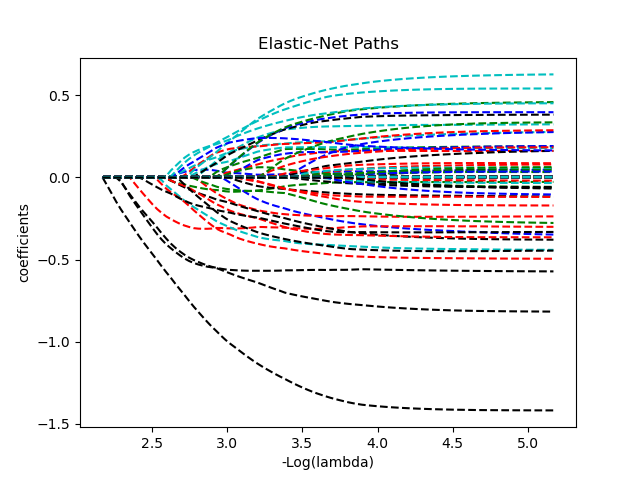

In [346]:
%matplotlib notebook
#plt.figure()
colors = cycle(['b', 'r', 'g', 'c', 'k'])
neg_log_alphas_enet = -np.log10(alphas_enet)
for coef_e, c in zip(coefs_enet, colors):
    #l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
    l2 = plt.plot(neg_log_alphas_enet, coef_e, linestyle='--', c=c)

plt.xlabel('-Log(lambda)')
plt.ylabel('coefficients')
plt.title('Elastic-Net Paths')
#plt.legend(( l2[-1]), ('Elastic-Net'), loc='lower left')
#plt.axis('tight')
plt.savefig('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/E_Net_path_X3_MRS')

In [ ]:
# normalize=True
alphas_enet, coefs_enet, _ = enet_path(X_3_k, k_MRS, l1_ratio=0.5, cv=10, random_state=0, normalize=True)
#enet_x3_n.fit(X_3_k, k_MRS)

In [292]:
-np.log(4)

-1.3862943611198906

In [ ]:
0.008817527626418459

In [359]:
coefs_enet.shape

(180, 100)

In [289]:
pd.DataFrame(alphas_enet)

,0
0,0.006752
1,0.006297
2,0.005873
3,0.005477
4,0.005108
...,...
95,0.000009
96,0.000008
97,0.000008
98,0.000007


In [288]:
plt.scatter(k_MRS, k_cadss, marker='x')

In [255]:
!pip install statsmodels

# Test Zone

In [295]:
import time

Results of the cross validation

Computing regularization path using the coordinate descent elastic net...


<IPython.core.display.Javascript object>


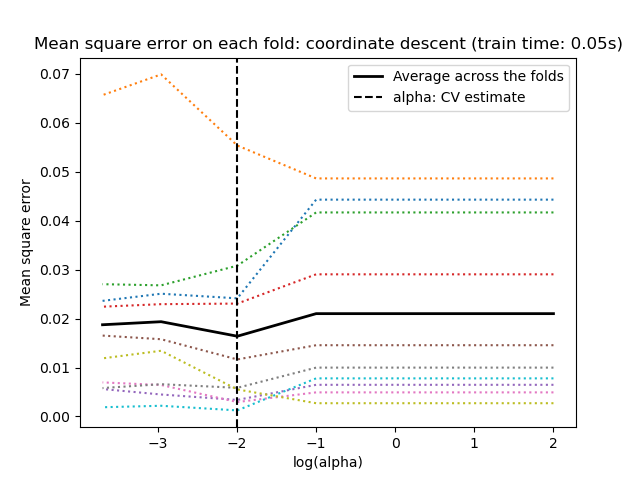

Text(0.5, 1.0, 'Mean square error on each fold: coordinate descent (train time: 0.05s)')

In [372]:
# LassoCV: coordinate descent
# This is to avoid division by zero while doing np.log10
EPSILON = 1e-4
# Compute paths
print("Computing regularization path using the coordinate descent elastic net...")
t1 = time.time()
# alphas in log space, get a training (21p) and test (6p) sets!
#you need
model = ElasticNetCV(cv=10, alphas=[1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],random_state=0, normalize=True, l1_ratio=0.5).fit(X_3_k, k_MRS)
t_elastic_cv = time.time() - t1

# Display results
m_log_alphas = np.log10(model.alphas_ + EPSILON)

plt.figure()
ymin, ymax = 2300, 3800
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(np.log10(model.alpha_ + EPSILON), linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel('log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent '
          '(train time: %.2fs)' % t_elastic_cv)
#plt.axis('tight')
#plt.xlim(0, 4)
#plt.savefig('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/MSE_Ket_X3_MRS')

In [373]:
model.alpha_

0.01

# Tutorial Datarobot

In [341]:
x3=pd.DataFrame(X_3_k)
x3_col=list(x3.columns)

In [ ]:
# first: split in train and test set
# think about your features and have a df with names/assignment
# figure out this stupid log scale thing

In [334]:
# fit model
model = ElasticNetCV(cv=10, random_state=0, normalize=True, l1_ratio=0.5).fit(X_3_k, k_MRS)

In [344]:
# optimal alpha
model.alpha_

0.008817527626418459

In [343]:
model.coef_

array([ 0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        ,  0.        ,  0.        , -0.        ,
       -0.        ,  0.        ,  0.        , -0.        , -0.        ,
        0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.06524248, -0.        ,  0.        ,  0.        ,  0.        ,
       -0.        , -0.31105355, -0.        ,  0.        , -0.        ,
       -0.        ,  0.        , -0.        ,  0.        , -0.72394238,
       -0.        , -0.        , -0.        , -0.        ,  0.        ,
        0.        , -0.        , -0.        ,  0.        , -0.        ,
        0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        , -0.        ,  0.        ,
        0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.        ,  0.  

In [342]:
labelled_coeffs_dict = {'labels' : x3_col,
                    'coefficient': model.coef_}

labelled_coeffs_frame = pd.DataFrame(labelled_coeffs_dict)

labelled_coeffs_frame

,labels,coefficient
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,-0.0
...,...,...
175,175,-0.0
176,176,0.0
177,177,0.0
178,178,-0.0


This shows how coefficient values fall to zero as we increase alpha. 

This can be used to indicate those most important features that are most robust to increasing the tuning parameter. 

Coefficient paths can also be drawn for the elastic net approach:

### Reading in the CADSS Scores for prediction

turn them to proper Y value

In [199]:
ket_csv=pd.read_csv('C:/Users/canlab/Desktop/Masterthesis_python/data/Ket_overview.csv')

In [200]:
ket_csv

,ID Nr.,Behandlungsart,CADSS
0,ap75,Placebo,0
1,bg52,Verum,35
2,bh27,Placebo,0
3,bh98,Verum,31
4,bu45,Placebo,0
...,...,...,...
86,xc25,Verum,0
87,xp38,Placebo,0
88,yh25,Verum,15
89,yp84,Verum,10


In [201]:
ket_subj_list

1     bg52
2     bh98
4     ce22
5     cu52
7     dp37
14    fy78
16    gs63
18    hw95
19    hy97
20    ia24
21    ia45
23    ii39
24    il04
25    ju09
26    jw73
28    kd21
31    kw91
35    op18
38    px00
39    qe30
41    sr21
43    tt42
44    uf97
45    vg84
48    wo30
49    ww25
52    yp84
Name: ID, dtype: object

In [205]:
split_csv = ket_csv.groupby('Behandlungsart')
# get the median correlation of the ROIs
k_csv_df = split_csv.get_group('Verum') 
p_csv_df = split_csv.get_group('Placebo') 

In [211]:
k_csv_df=k_csv_df.set_index('ID Nr.')

In [217]:
k_csv_df=k_csv_df.loc[ket_subj_list]
k_csv_df.to_pickle('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/CADSS_ket')
k_csv_df

,Behandlungsart,CADSS
ID Nr.,,
bg52,Verum,35
bh98,Verum,31
ce22,Verum,1
cu52,Verum,15
dp37,Verum,14
fy78,Verum,20
gs63,Verum,8
hw95,Verum,0
hy97,Verum,9


In [221]:
k_cadss= k_csv_df['CADSS'].to_numpy()
k_cadss

array([35, 31,  1, 15, 14, 20,  8,  0,  9, 23,  4, 14, 14, 14, 13,  3, 16,
        0,  1,  2,  1,  6, 10,  3,  4,  0, 10], dtype=int64)

In [216]:
p_csv_df=p_csv_df.set_index('ID Nr.')
p_csv_df=p_csv_df.loc[placebo_subj_list]
p_csv_df.to_pickle('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/CADSS_placebo')
p_csv_df

,Behandlungsart,CADSS
ID Nr.,,
ap75,Placebo,0
bu45,Placebo,0
dp20,Placebo,0
dp92,Placebo,0
dt27,Placebo,0
du02,Placebo,0
dw28,Placebo,0
em60,Placebo,0
ew27,Placebo,0


In [225]:
p_cadss= p_csv_df['CADSS'].to_numpy()
p_cadss

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int64)

## Elastic net with CADSS

In [229]:
regr_cadss_x1 = ElasticNetCV(cv=10, random_state=0)
regr_cadss_x1.fit(X_1_k, k_cadss)
regr_cadss_x1.coef_

array([-0.        , -0.        , -0.        ,  0.        , -0.        ,
       -0.        , -0.        ,  0.        , -0.        ,  0.        ,
        0.        , -0.        ,  0.        , -0.        , -0.        ,
       -0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.        ,  0.        , -0.        , -0.        ,  0.        ,
       -0.        , -0.        , -0.        , -0.        ,  0.        ,
       -0.        ,  0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        ,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        0.        , -0.        ,  0.        ,  0.        , -0.        ,
        0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.        , -0.        ,  0.        , -0.        , -0.        ,
       -0.        ,  0.        , -0.        ,  0.        ,  0.        ,
       -0.        , -0.08500266,  0.        , -0.        ,  0.31

In [242]:
regr_cadss_x1.score(X_1_k, k_cadss)

0.009004758149531833

In [248]:
# normalize
regr_cadss_x1_n = ElasticNetCV(cv=10, random_state=0, normalize=True)
regr_cadss_x1_n.fit(X_1_k, k_cadss)
regr_cadss_x1_n.coef_

array([-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  

In [230]:
regr_cadss_x2 = ElasticNetCV(cv=10, random_state=0)
regr_cadss_x2.fit(X_2_k, k_cadss)
regr_cadss_x2.coef_

array([-0., -0., -0., -0.,  0.,  0., -0., -0., -0., -0.,  0., -0., -0.,
        0.,  0., -0.,  0.,  0.,  0.,  0.,  0., -0., -0., -0., -0., -0.,
       -0.,  0.,  0.,  0., -0., -0., -0., -0., -0.,  0., -0.,  0.,  0.,
       -0.,  0., -0.,  0.,  0., -0., -0., -0.,  0.,  0.,  0., -0.,  0.,
       -0., -0.,  0., -0.,  0., -0.,  0.,  0., -0., -0., -0.,  0.,  0.,
        0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0.,  0., -0., -0.,  0.,  0.,  0., -0.,  0.,
       -0., -0.,  0., -0., -0., -0., -0.,  0., -0., -0., -0., -0.,  0.,
       -0.,  0., -0.,  0.,  0., -0.,  0.,  0.,  0., -0., -0.,  0., -0.,
       -0., -0., -0., -0.,  0.,  0., -0.,  0., -0.,  0.,  0., -0.,  0.,
        0., -0., -0., -0., -0.,  0.,  0.,  0.,  0., -0.,  0., -0., -0.,
       -0., -0.,  0.,  0.,  0.,  0., -0., -0.,  0., -0., -0., -0.,  0.,
       -0.,  0.,  0.,  0.,  0., -0., -0., -0.,  0.,  0., -0.,  0., -0.,
       -0., -0., -0., -0., -0., -0.,  0.,  0.,  0., -0., -0.])

In [233]:
regr_cadss_x3 = ElasticNetCV(cv=10, random_state=0)
regr_cadss_x3.fit(X_3_k, k_cadss)
regr_cadss_x3.coef_

array([-0.        , -0.95141689, -0.62864747, -0.        ,  0.        ,
       -0.        ,  2.07076472, -0.        ,  3.04237114, -0.        ,
        0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.        , -0.        , -0.        , -0.        ,  0.        ,
        0.        , -0.        , -0.02237944, -0.        , -0.        ,
       -0.        ,  0.        ,  0.42639524, -0.        , -0.11030781,
       -0.        , -0.        , -0.92018317, -0.        , -0.        ,
       -0.        ,  0.66185293, -0.        ,  0.        ,  0.        ,
        0.26442414, -0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.        ,  0.47957175,  1.05811343, -0.        ,
       -0.        ,  0.        , -0.        , -0.        ,  0.        ,
       -1.20173963,  0.        , -0.        ,  3.08918886, -1.93660692,
       -0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.02729473, -0.79409305,  2.47166189, -0.  

In [234]:
regr_cadss_x3.intercept_

10.086894874464187

In [238]:
x3_predict=regr_cadss_x3.predict(X_3_k)
x3_predict

array([11.66114706, 11.57735211,  9.93722743, 10.93679292,  9.58968084,
        9.99488565, 10.01192588,  9.75733612, 10.95284168, 10.45827919,
        9.45533247, 10.01746415, 10.39142158, 10.78964549,  9.98182707,
        9.24431123, 10.58897799,  8.75501836,  9.2983314 ,  9.75327466,
        9.30646896,  9.64600958, 11.23423635,  9.12018532,  9.44050252,
        9.13169806,  9.96782591])

In [239]:
x3_predict=regr_cadss_x3.predict(X_3_k)
x3_predict

array([11.66114706, 11.57735211,  9.93722743, 10.93679292,  9.58968084,
        9.99488565, 10.01192588,  9.75733612, 10.95284168, 10.45827919,
        9.45533247, 10.01746415, 10.39142158, 10.78964549,  9.98182707,
        9.24431123, 10.58897799,  8.75501836,  9.2983314 ,  9.75327466,
        9.30646896,  9.64600958, 11.23423635,  9.12018532,  9.44050252,
        9.13169806,  9.96782591])

In [241]:
regr_cadss_x3.score(X_3_k, k_cadss)

0.1246199346397543

In [249]:
# normalize
regr_cadss_x3_n = ElasticNetCV(cv=10, random_state=0, normalize=True)
regr_cadss_x3_n.fit(X_3_k, k_cadss)
regr_cadss_x3_n.coef_

array([-0.        , -0.        , -0.        , -0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  1.33366408, -0.        ,
        0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.        , -0.        , -0.        , -0.        ,  0.        ,
        0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        ,  0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.2471951 , -0.        , -0.        ,
       -0.        ,  0.        , -0.        ,  0.        ,  0.        ,
        0.        , -0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.        ,
       -0.        ,  0.        , -0.        , -0.        ,  0.        ,
       -0.50698695,  0.        , -0.        ,  1.11273639, -1.97320765,
       -0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -1.02513346,  1.43984662, -0.  

In [250]:
regr_cadss_x3_n.score(X_3_k, k_cadss)

0.055718663833327686

In [251]:
regr_cadss_x4 = ElasticNetCV(cv=10, random_state=0, normalize=True)
regr_cadss_x4.fit(X_4_k, k_cadss)
regr_cadss_x4.coef_

array([ 0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -

ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
             l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto', random_state=0,
             selection='cyclic', tol=0.0001, verbose=0)

array([-0.        , -0.95141689, -0.62864747, -0.        ,  0.        ,
       -0.        ,  2.07076472, -0.        ,  3.04237114, -0.        ,
        0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.        , -0.        , -0.        , -0.        ,  0.        ,
        0.        , -0.        , -0.02237944, -0.        , -0.        ,
       -0.        ,  0.        ,  0.42639524, -0.        , -0.11030781,
       -0.        , -0.        , -0.92018317, -0.        , -0.        ,
       -0.        ,  0.66185293, -0.        ,  0.        ,  0.        ,
        0.26442414, -0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.        ,  0.47957175,  1.05811343, -0.        ,
       -0.        ,  0.        , -0.        , -0.        ,  0.        ,
       -1.20173963,  0.        , -0.        ,  3.08918886, -1.93660692,
       -0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.02729473, -0.79409305,  2.47166189, -0.  

In [232]:
regr_cadss_x3.alpha_

0.08965612060474301

In [226]:
regr_cadss_p_x3 = ElasticNetCV(cv=10, random_state=0)
regr_cadss_p_x3.fit(X_3_p, p_cadss)

C:\Users\canlab\Anaconda3\envs\py37\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\canlab\Anaconda3\envs\py37\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\canlab\Anaconda3\envs\py37\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\canlab\Anaconda3\envs\py37\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users

ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
             l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto', random_state=0,
             selection='cyclic', tol=0.0001, verbose=0)

In [227]:
regr_cadss_p_x3.coef_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])